# Collect Tweets into MongoDB

## Install Python libraries

You may need to restart your Jupyter Notebook instance after installed those libraries.

In [1]:
!pip install pymongo

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [2]:
!pip install pymongo[srv]

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
!pip install dnspython

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [4]:
!pip install tweepy

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [5]:
!pip install twitter

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


## Import Python libraries

In [6]:
import pymongo
from pymongo import MongoClient
import json
import tweepy
import twitter
from pprint import pprint
import configparser
import pandas as pd

##  Load the Authorization Info

Save database connection info and API Keys in a config.ini file and use the configparse to load the authorization info. 

In [7]:
config = configparser.ConfigParser()
config.read('config.ini')

CONSUMER_KEY      = config['mytwitter']['api_key']
CONSUMER_SECRET   = config['mytwitter']['api_secrete']
OAUTH_TOKEN       = config['mytwitter']['access_token']
OATH_TOKEN_SECRET = config['mytwitter']['access_secrete']

mongod_connect = config['mymongo']['connection']

## Connect to the MongoDB Cluster

In [8]:
client = MongoClient(mongod_connect)
db = client.gp1 # use or create a database named demo
tweet_collection = db.final_project #use or create a collection named tweet_collection
tweet_collection.create_index([("id", pymongo.ASCENDING)],unique = True) # make sure the collected tweets are unique

'id_1'

## Use the Streaming API to Collect Tweets

Authorize the Stream API 

In [4]:
stream_auth = tweepy.OAuthHandler(CONSUMER_KEY, CONSUMER_SECRET)
stream_auth.set_access_token(OAUTH_TOKEN, OATH_TOKEN_SECRET)

strem_api = tweepy.API(stream_auth)

Define the query for the Stream API

In [5]:
track = ['election'] # define the keywords, tweets contain election

locations = [-78.9326449,38.4150904,-78.8816972,38.4450731] #defin the location, in Harrisonburg, VA

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> OR </span> are located in Harrisonburg, VA

In [ ]:
class MyStreamListener(tweepy.StreamListener):
    def on_status(self, status):
        print (status.id_str)
        try:
            tweet_collection.insert_one(status._json)
        except:
            pass
  
    def on_error(self, status_code):
        if status_code == 420:
            #returning False in on_data disconnects the stream
            return False
myStreamListener = MyStreamListener()
myStream = tweepy.Stream(auth = strem_api.auth, listener=myStreamListener)
myStream.filter(track=track)#  (locations = locations)   #Use either track or locations

## Use the REST API to Collect Tweets

Authorize the REST API 

In [11]:
rest_auth = twitter.oauth.OAuth(OAUTH_TOKEN,OATH_TOKEN_SECRET,CONSUMER_KEY,CONSUMER_SECRET)
rest_api = twitter.Twitter(auth=rest_auth)

Define the query for the REST API

In [12]:
count = 100 #number of returned tweets, default and max is 100
geocode = "44.6657247,-92.4148183,165mi"  # defin the location, in Harrisonburg, VA
q = "COVID19"                               #define the keywords, tweets contain election

The collected tweets will contain 'election' <span style="color:red;font-weight:bold"> AND </span> are located in Harrisonburg, VA

In [13]:
search_results = rest_api.search.tweets( count=count,q=q, geocode=geocode) #you can use both q and geocode
statuses = search_results["statuses"]
since_id_new = statuses[-1]['id']
for statuse in statuses:
    try:
        tweet_collection.insert_one(statuse)
        pprint(statuse['created_at'])# print the date of the collected tweets
    except:
        pass

'Thu Jan 14 21:14:07 +0000 2021'
'Thu Jan 14 21:06:19 +0000 2021'
'Thu Jan 14 21:03:02 +0000 2021'
'Thu Jan 14 21:01:12 +0000 2021'
'Thu Jan 14 20:59:09 +0000 2021'
'Thu Jan 14 20:56:40 +0000 2021'
'Thu Jan 14 20:54:21 +0000 2021'
'Thu Jan 14 20:50:00 +0000 2021'
'Thu Jan 14 20:49:50 +0000 2021'
'Thu Jan 14 20:46:38 +0000 2021'
'Thu Jan 14 20:45:17 +0000 2021'
'Thu Jan 14 20:41:55 +0000 2021'
'Thu Jan 14 20:39:33 +0000 2021'
'Thu Jan 14 20:39:24 +0000 2021'
'Thu Jan 14 20:38:49 +0000 2021'
'Thu Jan 14 20:37:17 +0000 2021'
'Thu Jan 14 20:35:19 +0000 2021'
'Thu Jan 14 20:31:53 +0000 2021'
'Thu Jan 14 20:28:15 +0000 2021'
'Thu Jan 14 20:27:48 +0000 2021'
'Thu Jan 14 20:27:48 +0000 2021'
'Thu Jan 14 20:26:22 +0000 2021'
'Thu Jan 14 20:26:15 +0000 2021'
'Thu Jan 14 20:20:23 +0000 2021'
'Thu Jan 14 20:17:53 +0000 2021'
'Thu Jan 14 20:17:23 +0000 2021'
'Thu Jan 14 20:17:15 +0000 2021'
'Thu Jan 14 20:17:00 +0000 2021'
'Thu Jan 14 20:10:39 +0000 2021'
'Thu Jan 14 20:10:18 +0000 2021'
'Thu Jan 1

Continue fetching early tweets with the same query. 
<p><span style="color:red;font-weight:bold">YOU WILL REACH YOUR RATE LIMIT VERY FAST</span></p>

In [14]:
since_id_old = 0
while(since_id_new != since_id_old):
    since_id_old = since_id_new
    search_results = rest_api.search.tweets( count=count,q=q,
                        geocode=geocode, max_id= since_id_new)
    statuses = search_results["statuses"]
    since_id_new = statuses[-1]['id']
    for statuse in statuses:
        try:
            tweet_collection.insert_one(statuse)
            pprint(statuse['created_at']) # print the date of the collected tweets
        except:
            pass

'Thu Jan 14 17:28:41 +0000 2021'
'Thu Jan 14 17:25:56 +0000 2021'
'Thu Jan 14 17:25:41 +0000 2021'
'Thu Jan 14 17:25:16 +0000 2021'
'Thu Jan 14 17:25:08 +0000 2021'
'Thu Jan 14 17:23:43 +0000 2021'
'Thu Jan 14 17:23:39 +0000 2021'
'Thu Jan 14 17:21:36 +0000 2021'
'Thu Jan 14 17:21:32 +0000 2021'
'Thu Jan 14 17:21:10 +0000 2021'
'Thu Jan 14 17:20:38 +0000 2021'
'Thu Jan 14 17:20:00 +0000 2021'
'Thu Jan 14 17:19:50 +0000 2021'
'Thu Jan 14 17:19:30 +0000 2021'
'Thu Jan 14 17:18:53 +0000 2021'
'Thu Jan 14 17:15:51 +0000 2021'
'Thu Jan 14 17:14:56 +0000 2021'
'Thu Jan 14 17:14:18 +0000 2021'
'Thu Jan 14 17:13:46 +0000 2021'
'Thu Jan 14 17:12:56 +0000 2021'
'Thu Jan 14 17:10:18 +0000 2021'
'Thu Jan 14 17:09:58 +0000 2021'
'Thu Jan 14 17:09:06 +0000 2021'
'Thu Jan 14 17:08:11 +0000 2021'
'Thu Jan 14 17:07:57 +0000 2021'
'Thu Jan 14 17:07:35 +0000 2021'
'Thu Jan 14 17:07:04 +0000 2021'
'Thu Jan 14 17:06:16 +0000 2021'
'Thu Jan 14 17:04:39 +0000 2021'
'Thu Jan 14 17:02:27 +0000 2021'
'Thu Jan 1

'Wed Jan 13 21:30:21 +0000 2021'
'Wed Jan 13 21:21:48 +0000 2021'
'Wed Jan 13 21:15:02 +0000 2021'
'Wed Jan 13 21:13:17 +0000 2021'
'Wed Jan 13 21:13:03 +0000 2021'
'Wed Jan 13 21:11:16 +0000 2021'
'Wed Jan 13 21:11:13 +0000 2021'
'Wed Jan 13 21:00:16 +0000 2021'
'Wed Jan 13 20:56:51 +0000 2021'
'Wed Jan 13 20:56:14 +0000 2021'
'Wed Jan 13 20:50:33 +0000 2021'
'Wed Jan 13 20:48:53 +0000 2021'
'Wed Jan 13 20:48:50 +0000 2021'
'Wed Jan 13 20:47:28 +0000 2021'
'Wed Jan 13 20:46:48 +0000 2021'
'Wed Jan 13 20:40:12 +0000 2021'
'Wed Jan 13 20:40:00 +0000 2021'
'Wed Jan 13 20:39:00 +0000 2021'
'Wed Jan 13 20:36:18 +0000 2021'
'Wed Jan 13 20:35:55 +0000 2021'
'Wed Jan 13 20:34:53 +0000 2021'
'Wed Jan 13 20:34:33 +0000 2021'
'Wed Jan 13 20:33:34 +0000 2021'
'Wed Jan 13 20:30:56 +0000 2021'
'Wed Jan 13 20:30:55 +0000 2021'
'Wed Jan 13 20:29:24 +0000 2021'
'Wed Jan 13 20:29:16 +0000 2021'
'Wed Jan 13 20:28:51 +0000 2021'
'Wed Jan 13 20:24:44 +0000 2021'
'Wed Jan 13 20:22:04 +0000 2021'
'Wed Jan 1

'Wed Jan 13 00:49:31 +0000 2021'
'Wed Jan 13 00:43:41 +0000 2021'
'Wed Jan 13 00:38:01 +0000 2021'
'Wed Jan 13 00:33:01 +0000 2021'
'Wed Jan 13 00:31:56 +0000 2021'
'Wed Jan 13 00:31:53 +0000 2021'
'Wed Jan 13 00:26:10 +0000 2021'
'Wed Jan 13 00:25:25 +0000 2021'
'Wed Jan 13 00:17:28 +0000 2021'
'Wed Jan 13 00:14:14 +0000 2021'
'Wed Jan 13 00:09:57 +0000 2021'
'Wed Jan 13 00:09:19 +0000 2021'
'Wed Jan 13 00:08:26 +0000 2021'
'Wed Jan 13 00:05:12 +0000 2021'
'Wed Jan 13 00:04:03 +0000 2021'
'Tue Jan 12 23:57:50 +0000 2021'
'Tue Jan 12 23:55:48 +0000 2021'
'Tue Jan 12 23:51:29 +0000 2021'
'Tue Jan 12 23:50:02 +0000 2021'
'Tue Jan 12 23:46:18 +0000 2021'
'Tue Jan 12 23:38:15 +0000 2021'
'Tue Jan 12 23:32:53 +0000 2021'
'Tue Jan 12 23:32:40 +0000 2021'
'Tue Jan 12 23:31:49 +0000 2021'
'Tue Jan 12 23:24:17 +0000 2021'
'Tue Jan 12 23:15:36 +0000 2021'
'Tue Jan 12 23:14:52 +0000 2021'
'Tue Jan 12 23:12:19 +0000 2021'
'Tue Jan 12 23:10:19 +0000 2021'
'Tue Jan 12 23:10:05 +0000 2021'
'Tue Jan 1

'Tue Jan 12 16:44:00 +0000 2021'
'Tue Jan 12 16:42:55 +0000 2021'
'Tue Jan 12 16:41:56 +0000 2021'
'Tue Jan 12 16:41:55 +0000 2021'
'Tue Jan 12 16:41:29 +0000 2021'
'Tue Jan 12 16:40:45 +0000 2021'
'Tue Jan 12 16:35:29 +0000 2021'
'Tue Jan 12 16:35:11 +0000 2021'
'Tue Jan 12 16:34:34 +0000 2021'
'Tue Jan 12 16:31:04 +0000 2021'
'Tue Jan 12 16:30:01 +0000 2021'
'Tue Jan 12 16:29:09 +0000 2021'
'Tue Jan 12 16:28:24 +0000 2021'
'Tue Jan 12 16:27:23 +0000 2021'
'Tue Jan 12 16:25:58 +0000 2021'
'Tue Jan 12 16:23:34 +0000 2021'
'Tue Jan 12 16:22:46 +0000 2021'
'Tue Jan 12 16:21:31 +0000 2021'
'Tue Jan 12 16:20:51 +0000 2021'
'Tue Jan 12 16:16:34 +0000 2021'
'Tue Jan 12 16:14:20 +0000 2021'
'Tue Jan 12 16:11:48 +0000 2021'
'Tue Jan 12 16:10:46 +0000 2021'
'Tue Jan 12 16:09:34 +0000 2021'
'Tue Jan 12 16:08:31 +0000 2021'
'Tue Jan 12 16:01:33 +0000 2021'
'Tue Jan 12 16:00:47 +0000 2021'
'Tue Jan 12 16:00:26 +0000 2021'
'Tue Jan 12 15:59:57 +0000 2021'
'Tue Jan 12 15:58:05 +0000 2021'
'Tue Jan 1

'Tue Jan 12 00:36:19 +0000 2021'
'Tue Jan 12 00:36:19 +0000 2021'
'Tue Jan 12 00:34:50 +0000 2021'
'Tue Jan 12 00:32:06 +0000 2021'
'Tue Jan 12 00:31:40 +0000 2021'
'Tue Jan 12 00:30:00 +0000 2021'
'Tue Jan 12 00:22:12 +0000 2021'
'Tue Jan 12 00:20:13 +0000 2021'
'Tue Jan 12 00:16:03 +0000 2021'
'Tue Jan 12 00:15:12 +0000 2021'
'Tue Jan 12 00:14:08 +0000 2021'
'Tue Jan 12 00:11:20 +0000 2021'
'Tue Jan 12 00:10:03 +0000 2021'
'Tue Jan 12 00:08:38 +0000 2021'
'Tue Jan 12 00:07:48 +0000 2021'
'Tue Jan 12 00:07:00 +0000 2021'
'Mon Jan 11 23:59:30 +0000 2021'
'Mon Jan 11 23:49:25 +0000 2021'
'Mon Jan 11 23:47:36 +0000 2021'
'Mon Jan 11 23:47:25 +0000 2021'
'Mon Jan 11 23:42:36 +0000 2021'
'Mon Jan 11 23:32:34 +0000 2021'
'Mon Jan 11 23:30:26 +0000 2021'
'Mon Jan 11 23:29:47 +0000 2021'
'Mon Jan 11 23:29:33 +0000 2021'
'Mon Jan 11 23:25:08 +0000 2021'
'Mon Jan 11 23:25:05 +0000 2021'
'Mon Jan 11 23:25:04 +0000 2021'
'Mon Jan 11 23:23:06 +0000 2021'
'Mon Jan 11 23:21:19 +0000 2021'
'Mon Jan 1

'Mon Jan 11 16:55:14 +0000 2021'
'Mon Jan 11 16:52:57 +0000 2021'
'Mon Jan 11 16:48:09 +0000 2021'
'Mon Jan 11 16:47:42 +0000 2021'
'Mon Jan 11 16:47:40 +0000 2021'
'Mon Jan 11 16:45:20 +0000 2021'
'Mon Jan 11 16:45:05 +0000 2021'
'Mon Jan 11 16:44:50 +0000 2021'
'Mon Jan 11 16:43:41 +0000 2021'
'Mon Jan 11 16:41:10 +0000 2021'
'Mon Jan 11 16:40:18 +0000 2021'
'Mon Jan 11 16:36:04 +0000 2021'
'Mon Jan 11 16:32:26 +0000 2021'
'Mon Jan 11 16:24:06 +0000 2021'
'Mon Jan 11 16:20:56 +0000 2021'
'Mon Jan 11 16:19:36 +0000 2021'
'Mon Jan 11 16:16:07 +0000 2021'
'Mon Jan 11 16:09:38 +0000 2021'
'Mon Jan 11 16:00:00 +0000 2021'
'Mon Jan 11 15:41:42 +0000 2021'
'Mon Jan 11 15:41:31 +0000 2021'
'Mon Jan 11 15:34:07 +0000 2021'
'Mon Jan 11 15:25:55 +0000 2021'
'Mon Jan 11 15:24:29 +0000 2021'
'Mon Jan 11 15:18:49 +0000 2021'
'Mon Jan 11 15:16:26 +0000 2021'
'Mon Jan 11 15:16:10 +0000 2021'
'Mon Jan 11 15:14:13 +0000 2021'
'Mon Jan 11 15:11:38 +0000 2021'
'Mon Jan 11 15:11:05 +0000 2021'
'Mon Jan 1

'Sun Jan 10 13:19:10 +0000 2021'
'Sun Jan 10 13:08:17 +0000 2021'
'Sun Jan 10 13:02:23 +0000 2021'
'Sun Jan 10 12:57:45 +0000 2021'
'Sun Jan 10 12:56:25 +0000 2021'
'Sun Jan 10 12:38:37 +0000 2021'
'Sun Jan 10 12:30:07 +0000 2021'
'Sun Jan 10 12:24:51 +0000 2021'
'Sun Jan 10 12:18:17 +0000 2021'
'Sun Jan 10 12:17:17 +0000 2021'
'Sun Jan 10 12:16:49 +0000 2021'
'Sun Jan 10 11:39:50 +0000 2021'
'Sun Jan 10 11:39:48 +0000 2021'
'Sun Jan 10 11:00:44 +0000 2021'
'Sun Jan 10 08:09:00 +0000 2021'
'Sun Jan 10 06:04:16 +0000 2021'
'Sun Jan 10 05:39:16 +0000 2021'
'Sun Jan 10 05:21:57 +0000 2021'
'Sun Jan 10 05:12:56 +0000 2021'
'Sun Jan 10 05:12:47 +0000 2021'
'Sun Jan 10 05:12:23 +0000 2021'
'Sun Jan 10 05:12:19 +0000 2021'
'Sun Jan 10 05:05:16 +0000 2021'
'Sun Jan 10 04:53:06 +0000 2021'
'Sun Jan 10 04:52:30 +0000 2021'
'Sun Jan 10 04:45:04 +0000 2021'
'Sun Jan 10 04:44:47 +0000 2021'
'Sun Jan 10 04:39:23 +0000 2021'
'Sun Jan 10 04:34:46 +0000 2021'
'Sun Jan 10 04:31:42 +0000 2021'
'Sun Jan 1

'Sat Jan 09 02:42:32 +0000 2021'
'Sat Jan 09 02:32:26 +0000 2021'
'Sat Jan 09 02:32:04 +0000 2021'
'Sat Jan 09 02:29:16 +0000 2021'
'Sat Jan 09 02:22:50 +0000 2021'
'Sat Jan 09 02:14:00 +0000 2021'
'Sat Jan 09 02:11:31 +0000 2021'
'Sat Jan 09 02:09:49 +0000 2021'
'Sat Jan 09 02:03:22 +0000 2021'
'Sat Jan 09 02:01:54 +0000 2021'
'Sat Jan 09 02:01:48 +0000 2021'
'Sat Jan 09 01:55:06 +0000 2021'
'Sat Jan 09 01:52:55 +0000 2021'
'Sat Jan 09 01:50:27 +0000 2021'
'Sat Jan 09 01:50:09 +0000 2021'
'Sat Jan 09 01:49:00 +0000 2021'
'Sat Jan 09 01:44:40 +0000 2021'
'Sat Jan 09 01:39:06 +0000 2021'
'Sat Jan 09 01:37:17 +0000 2021'
'Sat Jan 09 01:36:33 +0000 2021'
'Sat Jan 09 01:33:56 +0000 2021'
'Sat Jan 09 01:31:19 +0000 2021'
'Sat Jan 09 01:24:44 +0000 2021'
'Sat Jan 09 01:24:34 +0000 2021'
'Sat Jan 09 01:21:36 +0000 2021'
'Sat Jan 09 01:21:30 +0000 2021'
'Sat Jan 09 01:17:07 +0000 2021'
'Sat Jan 09 01:15:59 +0000 2021'
'Sat Jan 09 01:12:57 +0000 2021'
'Sat Jan 09 01:08:21 +0000 2021'
'Sat Jan 0

'Fri Jan 08 17:54:29 +0000 2021'
'Fri Jan 08 17:51:05 +0000 2021'
'Fri Jan 08 17:50:16 +0000 2021'
'Fri Jan 08 17:49:36 +0000 2021'
'Fri Jan 08 17:48:13 +0000 2021'
'Fri Jan 08 17:46:07 +0000 2021'
'Fri Jan 08 17:45:50 +0000 2021'
'Fri Jan 08 17:42:59 +0000 2021'
'Fri Jan 08 17:42:14 +0000 2021'
'Fri Jan 08 17:39:49 +0000 2021'
'Fri Jan 08 17:38:38 +0000 2021'
'Fri Jan 08 17:37:17 +0000 2021'
'Fri Jan 08 17:33:37 +0000 2021'
'Fri Jan 08 17:24:04 +0000 2021'
'Fri Jan 08 17:21:45 +0000 2021'
'Fri Jan 08 17:20:13 +0000 2021'
'Fri Jan 08 17:17:44 +0000 2021'
'Fri Jan 08 17:17:19 +0000 2021'
'Fri Jan 08 17:16:29 +0000 2021'
'Fri Jan 08 17:16:23 +0000 2021'
'Fri Jan 08 17:15:18 +0000 2021'
'Fri Jan 08 17:15:12 +0000 2021'
'Fri Jan 08 17:14:23 +0000 2021'
'Fri Jan 08 17:14:08 +0000 2021'
'Fri Jan 08 17:13:24 +0000 2021'
'Fri Jan 08 17:12:14 +0000 2021'
'Fri Jan 08 17:11:39 +0000 2021'
'Fri Jan 08 17:10:46 +0000 2021'
'Fri Jan 08 17:08:19 +0000 2021'
'Fri Jan 08 17:05:05 +0000 2021'
'Fri Jan 0

'Fri Jan 08 00:33:31 +0000 2021'
'Fri Jan 08 00:30:59 +0000 2021'
'Fri Jan 08 00:30:34 +0000 2021'
'Fri Jan 08 00:30:05 +0000 2021'
'Fri Jan 08 00:30:00 +0000 2021'
'Fri Jan 08 00:29:05 +0000 2021'
'Fri Jan 08 00:27:58 +0000 2021'
'Fri Jan 08 00:27:44 +0000 2021'
'Fri Jan 08 00:26:01 +0000 2021'
'Fri Jan 08 00:24:25 +0000 2021'
'Fri Jan 08 00:24:03 +0000 2021'
'Fri Jan 08 00:23:47 +0000 2021'
'Fri Jan 08 00:23:45 +0000 2021'
'Fri Jan 08 00:21:45 +0000 2021'
'Fri Jan 08 00:21:02 +0000 2021'
'Fri Jan 08 00:20:23 +0000 2021'
'Fri Jan 08 00:20:07 +0000 2021'
'Fri Jan 08 00:19:41 +0000 2021'
'Fri Jan 08 00:18:50 +0000 2021'
'Fri Jan 08 00:17:31 +0000 2021'
'Fri Jan 08 00:16:00 +0000 2021'
'Fri Jan 08 00:15:30 +0000 2021'
'Fri Jan 08 00:13:30 +0000 2021'
'Fri Jan 08 00:11:20 +0000 2021'
'Fri Jan 08 00:10:17 +0000 2021'
'Fri Jan 08 00:09:42 +0000 2021'
'Fri Jan 08 00:06:33 +0000 2021'
'Fri Jan 08 00:06:06 +0000 2021'
'Fri Jan 08 00:01:50 +0000 2021'
'Fri Jan 08 00:00:56 +0000 2021'
'Fri Jan 0

'Thu Jan 07 19:04:47 +0000 2021'
'Thu Jan 07 19:04:42 +0000 2021'
'Thu Jan 07 19:01:43 +0000 2021'
'Thu Jan 07 19:00:40 +0000 2021'
'Thu Jan 07 19:00:22 +0000 2021'
'Thu Jan 07 19:00:08 +0000 2021'
'Thu Jan 07 18:58:10 +0000 2021'
'Thu Jan 07 18:55:24 +0000 2021'
'Thu Jan 07 18:54:25 +0000 2021'
'Thu Jan 07 18:53:13 +0000 2021'
'Thu Jan 07 18:53:04 +0000 2021'
'Thu Jan 07 18:50:11 +0000 2021'
'Thu Jan 07 18:49:11 +0000 2021'
'Thu Jan 07 18:48:12 +0000 2021'
'Thu Jan 07 18:46:40 +0000 2021'
'Thu Jan 07 18:45:24 +0000 2021'
'Thu Jan 07 18:44:58 +0000 2021'
'Thu Jan 07 18:44:57 +0000 2021'
'Thu Jan 07 18:43:37 +0000 2021'
'Thu Jan 07 18:42:39 +0000 2021'
'Thu Jan 07 18:38:59 +0000 2021'
'Thu Jan 07 18:37:45 +0000 2021'
'Thu Jan 07 18:37:27 +0000 2021'
'Thu Jan 07 18:34:49 +0000 2021'
'Thu Jan 07 18:33:00 +0000 2021'
'Thu Jan 07 18:29:43 +0000 2021'
'Thu Jan 07 18:28:45 +0000 2021'
'Thu Jan 07 18:28:14 +0000 2021'
'Thu Jan 07 18:23:32 +0000 2021'
'Thu Jan 07 18:22:38 +0000 2021'
'Thu Jan 0

'Thu Jan 07 15:46:33 +0000 2021'
'Thu Jan 07 15:45:30 +0000 2021'
'Thu Jan 07 15:45:19 +0000 2021'
'Thu Jan 07 15:45:08 +0000 2021'
'Thu Jan 07 15:44:59 +0000 2021'
'Thu Jan 07 15:44:59 +0000 2021'
'Thu Jan 07 15:44:57 +0000 2021'
'Thu Jan 07 15:44:41 +0000 2021'
'Thu Jan 07 15:42:50 +0000 2021'
'Thu Jan 07 15:42:48 +0000 2021'
'Thu Jan 07 15:42:38 +0000 2021'
'Thu Jan 07 15:41:38 +0000 2021'
'Thu Jan 07 15:40:06 +0000 2021'
'Thu Jan 07 15:39:58 +0000 2021'
'Thu Jan 07 15:39:33 +0000 2021'
'Thu Jan 07 15:38:33 +0000 2021'
'Thu Jan 07 15:38:16 +0000 2021'
'Thu Jan 07 15:35:00 +0000 2021'
'Thu Jan 07 15:34:16 +0000 2021'
'Thu Jan 07 15:34:14 +0000 2021'
'Thu Jan 07 15:33:38 +0000 2021'
'Thu Jan 07 15:31:38 +0000 2021'
'Thu Jan 07 15:31:29 +0000 2021'
'Thu Jan 07 15:29:46 +0000 2021'
'Thu Jan 07 15:28:50 +0000 2021'
'Thu Jan 07 15:28:02 +0000 2021'
'Thu Jan 07 15:27:22 +0000 2021'
'Thu Jan 07 15:27:20 +0000 2021'
'Thu Jan 07 15:27:12 +0000 2021'
'Thu Jan 07 15:26:52 +0000 2021'
'Thu Jan 0

KeyboardInterrupt: 

## View the Collected Tweets

Print the number of tweets and unique twitter users

In [22]:
print(tweet_collection.estimated_document_count())# number of tweets collected

user_cursor = tweet_collection.distinct("user.id")
print (len(user_cursor)) # number of unique Twitter users 

3070
2112


Create a text index and print the Tweets containing specific keywords. 

In [23]:
tweet_collection.create_index([("text", pymongo.TEXT)], name='text_index', default_language='english') # create a text index


'text_index'

Create a cursor to query tweets with the created index

In [27]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "COVID19"}}) # return tweets contain vote

Use pprint to display tweets

In [28]:

for document in tweet_cursor[0:10]: # display the first 10 tweets from the query
    try:
        print ('----')
#         pprint (document) # use pprint to print the entire tweet document
   
        print ('name:', document["user"]["name"]) # user name
        print ('text:', document["text"])         # tweets
    except:
        print ("***error in encoding")
        pass

----
name: 🌞🆁 🅰 🅼🌞
text: Night curfew in France 
#COVIDー19 #COVID19
----
name: Jan Bern ☮️ Free Julian ⏳ #GoGreen2020🍀💚🌲
text: @BernieSanders @WorkingFamilies You mean pre-covid19 $, right?

That's about $30 in post-covid19 $.
----
name: UNI Student Wellness Services
text: 😷Remember to wear your mask to stop the spread of #COVID19. 
🙌Wash your hands 
👫Watch your distance
#COVID19… https://t.co/e2euKfT919
----
name: Word Salad with Cheez
text: @victorjacobo_ @jessieopie @DHSWI This a covid19 variant, not a covid19 strain.
https://t.co/1oIpfZfvQK https://t.co/z1duQXYEFK
----
name: CarverCoPublicHealth
text: Questions about the #COVID19 vaccine? Check out our #COVID19 vaccine information web page! We plan to use this page… https://t.co/nzaaANbgLD
----
name: WSAW
text: #COVID19 Stats: This week in North Central Wisconsin there were nearly 2,100 new #COVID19 cases and 31 new deaths.… https://t.co/lomA5uVYVJ
----
name: Jeremy Tabin
text: #COVID19 Stats: This week in North Central Wisconsin t

In [29]:
tweet_cursor = tweet_collection.find({"$text": {"$search": "COVID19"}}) # return tweets contain vote

Use pandas to display tweets

In [30]:
tweet_df = pd.DataFrame(list(tweet_cursor ))
tweet_df[:10] #display the first 10 tweets

,_id,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,...,favorite_count,favorited,retweeted,lang,possibly_sensitive,extended_entities,quoted_status_id,quoted_status_id_str,quoted_status,retweeted_status
0,6000b4a9794ca82b57abb357,Thu Jan 14 16:23:15 +0000 2021,1349753957560713217,1349753957560713217,Night curfew in France \n#COVIDー19 #COVID19,False,"{'hashtags': [{'text': 'COVIDー19', 'indices': ...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
1,6000b4bd794ca82b57abb973,Sun Jan 10 03:49:41 +0000 2021,1348114765881745409,1348114765881745409,@BernieSanders @WorkingFamilies You mean pre-c...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.346491e+18,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
2,6000b4c7794ca82b57abbcc2,Thu Jan 07 22:51:00 +0000 2021,1347314822405382144,1347314822405382144,😷Remember to wear your mask to stop the spread...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://about.twitter.com/products/tw...",NaN,...,1,False,False,en,False,NaN,NaN,NaN,NaN,NaN
3,6000b4ad794ca82b57abb488,Wed Jan 13 17:29:41 +0000 2021,1349408287108849665,1349408287108849665,@victorjacobo_ @jessieopie @DHSWI This a covid...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.349390e+18,...,0,False,False,en,False,"{'media': [{'id': 1349408281446514690, 'id_str...",NaN,NaN,NaN,NaN
4,6000b4c2794ca82b57abbb10,Fri Jan 08 19:50:43 +0000 2021,1347631842099404802,1347631842099404802,Questions about the #COVID19 vaccine? Check ou...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,...,1,False,False,en,False,NaN,NaN,NaN,NaN,NaN
5,6000b4be794ca82b57abb9c3,Sat Jan 09 22:22:55 +0000 2021,1348032531816476678,1348032531816476678,#COVID19 Stats: This week in North Central Wis...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://www.socialnewsdesk.com"" rel=""n...",NaN,...,0,False,False,en,False,NaN,NaN,NaN,NaN,NaN
6,6000b4be794ca82b57abb9c2,Sat Jan 09 22:23:05 +0000 2021,1348032574623461378,1348032574623461378,#COVID19 Stats: This week in North Central Wis...,True,"{'hashtags': [{'text': 'COVID19', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://www.socialnewsdesk.com"" rel=""n...",NaN,...,0,False,False,en,False,NaN,NaN,NaN,NaN,NaN
7,6000b4ae794ca82b57abb4d2,Wed Jan 13 14:04:50 +0000 2021,1349356737254592513,1349356737254592513,@NEJM Covid19?,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.349356e+18,...,0,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
8,6000b4c9794ca82b57abbd47,Thu Jan 07 20:11:01 +0000 2021,1347274562086559744,1347274562086559744,@ssppooffyy covid19 can't stop me &gt;:),False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.347274e+18,...,76,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN
9,6000b4af794ca82b57abb540,Wed Jan 13 00:38:01 +0000 2021,1349153696349827073,1349153696349827073,@LydiaBlackXo @TalentTesting It test for Covid19?,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",1.349123e+18,...,1,False,False,en,NaN,NaN,NaN,NaN,NaN,NaN


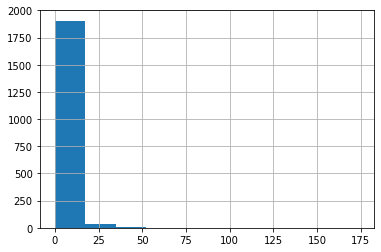

In [31]:
tweet_df["favorite_count"].hist() # create a histogram show the favorite count